# Week 2 Project

**Students**: Sergio Casas Pastor, Sanket Biswas and Josep Brugués i Pujolràs

**TEST CODE**

In [1]:
import cv2
import numpy as np
import cPickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import time
from matplotlib import pyplot as plt

Let us first read the train and test files

In [2]:
train_images_filenames = cPickle.load(open('train_images_filenames.dat','r'))
test_images_filenames = cPickle.load(open('test_images_filenames.dat','r'))
train_labels = cPickle.load(open('train_labels.dat','r'))
test_labels = cPickle.load(open('test_labels.dat','r'))

In [3]:
train_images_filenames[12]

'../../Databases/MIT_split/train/Opencountry/fie26.jpg'

We create a SIFT object detector and descriptor

In [4]:
SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures=900)
start = time.time()

We compute different spatial pyramid level

In [5]:
level = 4
level = 2**(level-1)

We compute the SIFT descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together

In [6]:
Train_descriptors = []
Train_label_per_descriptor = []

for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    
    # Resize image
    scale_percent = 100 # percent of original size
    width = int(ima.shape[1] * scale_percent / 100)
    height = int(ima.shape[0] * scale_percent / 100)
    dim = (width, height)
    ima = cv2.resize(ima, dim, interpolation = cv2.INTER_AREA) 
    
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
    step = 8 # Separation of pixels between keypoints
    descriptors = []

    # Compute spatial pyramids
    height_block = int(np.ceil(ima.shape[0] / level))  # Number of height pixels for sub-image
    width_block = int(np.ceil(ima.shape[1] / level))   # Number of width pixels for sub-image
    
    for height in range(0, ima.shape[0], height_block):
        for width in range(0, ima.shape[1], width_block):
            block = gray[height:height + height_block, width:width + width_block]
            keypoints_block = []
            
            for i in range(step/2, block.shape[0], step):
                for j in range(step/2, block.shape[1], step):             
                    keypoints_block.append(cv2.KeyPoint(i, j, step))
     
            _, descriptors_block = SIFTdetector.compute(block,keypoints_block)
            descriptors.extend(descriptors_block)
    
    Train_descriptors.append(descriptors)
    Train_label_per_descriptor.append(labels)

D=np.vstack(Train_descriptors)

We now compute a k-means clustering on the descriptor space

In [7]:
k = 170
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(D)

MiniBatchKMeans(batch_size=3400, compute_labels=False, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=170, n_init=3, random_state=42,
        reassignment_ratio=0.0001, tol=0.0, verbose=False)

And, for each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.

In [8]:
visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
for i in xrange(len(Train_descriptors)):
    words=codebook.predict(Train_descriptors[i])
    visual_words[i,:]=np.bincount(words,minlength=k)

We build a k-nn classifier and train it with the train descriptors

In [9]:
knn = KNeighborsClassifier(n_neighbors=10,n_jobs=-1,metric='euclidean')
knn.fit(visual_words, train_labels) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
           weights='uniform')

We end up computing the test descriptors and compute the accuracy of the model

In [10]:
visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for image in range(len(test_images_filenames)):
    filename=test_images_filenames[image]
    ima=cv2.imread(filename)
    
    # Resize image
    width = int(ima.shape[1] * scale_percent / 100)
    height = int(ima.shape[0] * scale_percent / 100)
    dim = (width, height)
    ima = cv2.resize(ima, dim, interpolation = cv2.INTER_AREA) 
    
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
            
    descriptors = []

    # Compute spatial pyramids
    height_block = int(np.ceil(ima.shape[0] / level))  # Number of height pixels for sub-image
    width_block = int(np.ceil(ima.shape[1] / level))    # Number of width pixels for sub-image
    for height in range(0, ima.shape[0], height_block):
        for width in range(0, ima.shape[1], width_block):
            block = gray[height:height + height_block, width:width + width_block]
            keypoints_block = []
    
            for i in range(step/2, block.shape[0], step):
                for j in range(step/2, block.shape[1], step):             
                    keypoints_block.append(cv2.KeyPoint(i, j, step))
            
            _, descriptors_block = SIFTdetector.compute(block,keypoints_block)   
            descriptors.extend(descriptors_block)

    words=codebook.predict(descriptors)
    visual_words_test[image,:]=np.bincount(words,minlength=k)    

In [11]:
accuracy = 100*knn.score(visual_words_test, test_labels)
print(accuracy)
end = time.time()
print(end - start)

65.79925650557621
158.379598856


Dimensionality reduction, with PCA and LDA

In [12]:
pca = PCA(n_components=64)
VWpca = pca.fit_transform(visual_words)
knnpca = KNeighborsClassifier(n_neighbors=20,n_jobs=-1,metric='euclidean')
knnpca.fit(VWpca, train_labels) 
vwtestpca = pca.transform(visual_words_test)
accuracy = 100*knnpca.score(vwtestpca, test_labels)
print(accuracy)

66.91449814126395


In [13]:
lda = LinearDiscriminantAnalysis(n_components=64)
VWlda = lda.fit_transform(visual_words,train_labels)
knnlda = KNeighborsClassifier(n_neighbors=20,n_jobs=-1,metric='euclidean')
knnlda.fit(VWlda, train_labels) 
vwtestlda = lda.transform(visual_words_test)
accuracy = 100*knnlda.score(vwtestlda, test_labels)
print(accuracy)

/Users/josep/Documents/Python/venv27/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


70.38413878562577


**RESULTS AND DISCUSSION**

We first implemented Dense SIFT. Compared to last weeks's results, 
we improved around 10-15%, depending on dimensionality reduction and other factors.
Then, we analysed the behaviour of Dense SIFT when changing the number of pixels between keypoints.
The results can be seen in the following graphic:

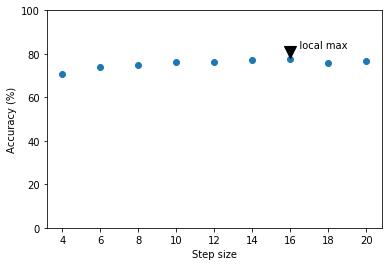

Local max is 77.69 % accuracy at step= 16
Local max is 77.69 % PCA accuracy at step= 12
Local max is 84.13 % LDA accuracy at step= 6


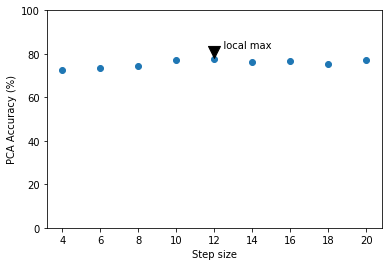

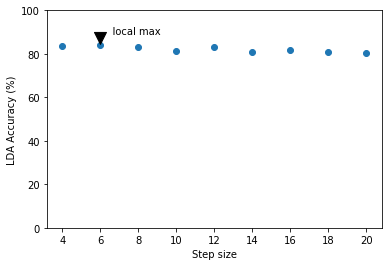

In [14]:
step = [4,6,8,10,12,14,16,18,20]
accuracy = [70.63,74.10,75.09,76.08,76.08,77.32,77.69,75.58,76.70]
lda_accuracy = [83.39,84.13,83.27,81.16,83.27,81.04,81.9,80.79,80.17]
pca_accuracy = [72.49,73.60,74.34,77.32,77.69,76.08,76.70,75.24,77.19]

plt.scatter(step, accuracy)
plt.ylim((0, 100))
plt.xlabel("Step size")
plt.ylabel("Accuracy (%)")
ymax = max(accuracy)
xpos = accuracy.index(ymax)
xmax = step[xpos]
plt.annotate('   local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.show()
print "Local max is", ymax,"% accuracy at step=",xmax

plt.scatter(step, pca_accuracy)
plt.ylim((0, 100))
plt.xlabel("Step size")
plt.ylabel("PCA Accuracy (%)")
ymax = max(pca_accuracy)
xpos = pca_accuracy.index(ymax)
xmax = step[xpos]
plt.annotate('   local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.show()
print "Local max is", ymax,"% PCA accuracy at step=",xmax


plt.scatter(step, lda_accuracy)
plt.ylim((0, 100))
plt.xlabel("Step size")
plt.ylabel("LDA Accuracy (%)")
ymax = max(lda_accuracy)
xpos = lda_accuracy.index(ymax)
xmax = step[xpos]
plt.annotate('    local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)

plt.show()
print "Local max is", ymax,"% LDA accuracy at step=",xmax


We ave decided that a step of 8 pixels is the best one, as it accomplishes
one of the best LDA accuracies while not taking much time to complete the computations.

After that, we resized the images to new scales to see if the performance 
could be further improved:

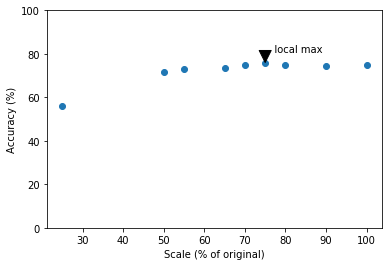

Local max is 75.83 % accuracy at scale= 75
Local max is 75.71 % PCA accuracy at scale= 70
Local max is 83.27 % LDA accuracy at scale= 100


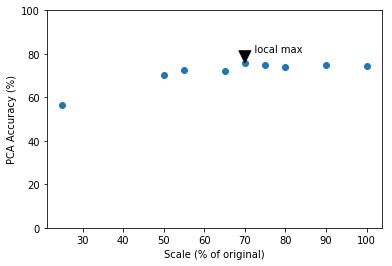

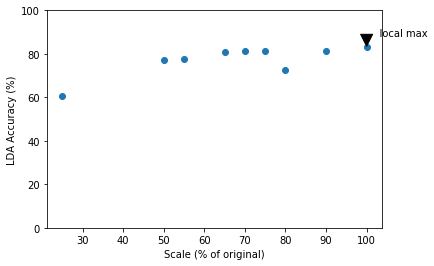

In [15]:
scale = [100,90,80,75,70,65,55,50,25]
accuracy = [75.09,74.47,74.72,75.83,75.09,73.60,72.86,71.49,55.88]
lda_accuracy = [83.27,81.53,72.42,81.53,81.53,80.66,77.57,77.32,60.47]
pca_accuracy = [74.34,74.71,74.10,74.84,75.71,72.24,72.49,70.38,56.50]

plt.scatter(scale, accuracy)
plt.ylim((0, 100))
plt.xlabel("Scale (% of original)")
plt.ylabel("Accuracy (%)")
ymax = max(accuracy)
xpos = accuracy.index(ymax)
xmax = scale[xpos]
plt.annotate('   local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.show()
print "Local max is", ymax,"% accuracy at scale=",xmax

plt.scatter(scale, pca_accuracy)
plt.ylim((0, 100))
plt.xlabel("Scale (% of original)")
plt.ylabel("PCA Accuracy (%)")
ymax = max(pca_accuracy)
xpos = pca_accuracy.index(ymax)
xmax = scale[xpos]
plt.annotate('   local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.show()
print "Local max is", ymax,"% PCA accuracy at scale=",xmax


plt.scatter(scale, lda_accuracy)
plt.ylim((0, 100))
plt.xlabel("Scale (% of original)")
plt.ylabel("LDA Accuracy (%)")
ymax = max(lda_accuracy)
xpos = lda_accuracy.index(ymax)
xmax = scale[xpos]
plt.annotate('    local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)

plt.show()
print "Local max is", ymax,"% LDA accuracy at scale=",xmax

As it can be seen from before, the best results are accomplished when the image
is not resized (we take into account the highest accuracy, LDA at scale 100%).

